In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


file_path = "D:/Sem6/COMP 262 - NLP and Recommender Systems/Project/AMAZON_FASHION.json"

reviews = []
with open(file_path, "r") as file:
    for line in file:
        reviews.append(json.loads(line))
    
df_original = pd.DataFrame.from_dict(reviews)

In [2]:
df_original.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image'],
      dtype='object')

In [3]:
df = pd.DataFrame(df_original, columns = ['overall', 'reviewText', 'summary', 'asin'])


In [4]:
df['review'] =  df['reviewText'] + ' ' + df['summary']

In [5]:
df = df [['overall', 'review', 'asin']]

In [6]:
df.shape

(883636, 3)

In [7]:
df = df.drop_duplicates()

In [8]:
df.shape

(873740, 3)

In [9]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

In [10]:
df['review'] = df['review'].astype('U').apply(preprocess_text)

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
df['review'] = df['review'].apply(lambda x: ' '.join([word for word in word_tokenize(x.lower()) if word not in stop_words]))


In [12]:
df.head()

,overall,review,asin
0,5.0,exactly needed perfect replacements,7106116521
1,2.0,agree review opening small almost bent hook ex...,7106116521
2,4.0,love going order another pack keep work someon...,7106116521
3,2.0,tiny opening two stars,7106116521
4,3.0,okay three stars,7106116521


In [13]:
df = df[df['review'] != ' ']

In [14]:
df.shape

(873740, 3)

## Using LDA approach

In [15]:
asin_value_counts = df['asin'].value_counts()
print(asin_value_counts)


asin
B000V0IBDM    4293
B000KPIHQ4    4284
B00I0VHS10    3822
B00RLSCLJM    3542
B000PHANNM    2511
              ... 
B00VQH61O0       1
B00VQGEHII       1
B00VQGZT76       1
B00VQCTMZ0       1
B01HJG5NMW       1
Name: count, Length: 186189, dtype: int64


In [16]:
asin_value_counts.head(20)

asin
B000V0IBDM    4293
B000KPIHQ4    4284
B00I0VHS10    3822
B00RLSCLJM    3542
B000PHANNM    2511
B00201ER88    2186
B00GXE331K    2000
B000P0X15G    1910
B00XT15P8E    1831
B005N7YWX6    1682
B004HX6P1E    1641
B009RUKQ2G    1575
B000JOOR7O    1547
B00ZW3SCF0    1505
B00XTM0ZPG    1395
B000GHMRLW    1382
B000GHRZN2    1382
B00NIVAEG8    1364
B00IJHMPE0    1335
B0183JQHCO    1229
Name: count, dtype: int64

In [17]:
top_asin = asin_value_counts.head(20).index

selected_reviews = []
for asin in top_asin:
    reviews = df[df['asin'] == asin].head(200)
    selected_reviews.append(reviews)

selected_reviews_df = pd.concat(selected_reviews)


In [18]:
selected_reviews_df.head()

,overall,review,asin
24715,5.0,lo ed old style much better thanks great improved,B000V0IBDM
24716,3.0,average insole three stars,B000V0IBDM
24717,5.0,buy new pair every six months feet lot really ...,B000V0IBDM
24718,5.0,podiatrist recommended powerstep insoles offer...,B000V0IBDM
24719,3.0,worked well first weeks went little hill every...,B000V0IBDM


In [19]:
selected_reviews_df['asin'].value_counts()

asin
B000V0IBDM    200
B000KPIHQ4    200
B00IJHMPE0    200
B00NIVAEG8    200
B000GHRZN2    200
B000GHMRLW    200
B00XTM0ZPG    200
B00ZW3SCF0    200
B000JOOR7O    200
B009RUKQ2G    200
B004HX6P1E    200
B005N7YWX6    200
B00XT15P8E    200
B000P0X15G    200
B00GXE331K    200
B00201ER88    200
B000PHANNM    200
B00RLSCLJM    200
B00I0VHS10    200
B0183JQHCO    200
Name: count, dtype: int64

In [20]:
from nltk.tokenize import word_tokenize
from gensim import corpora, models
text_data = []
for review in selected_reviews_df['review']:
    tokens = word_tokenize(review)
    text_data.append(tokens)

In [21]:
dictionary = corpora.Dictionary(text_data)

In [22]:
corpus = [dictionary.doc2bow(text) for text in text_data]

In [23]:
lda_model = models.LdaModel(corpus=corpus, num_topics=20, id2word=dictionary)

In [24]:
print(lda_model.print_topics())

[(0, '0.062*"stars" + 0.053*"five" + 0.052*"great" + 0.030*"purse" + 0.020*"good" + 0.020*"dress" + 0.016*"quality" + 0.015*"product" + 0.011*"fits" + 0.009*"cute"'), (1, '0.038*"great" + 0.021*"fit" + 0.017*"price" + 0.015*"hat" + 0.014*"quality" + 0.014*"loved" + 0.009*"purchase" + 0.008*"butt" + 0.008*"big" + 0.008*"really"'), (2, '0.036*"stars" + 0.027*"good" + 0.023*"five" + 0.022*"bag" + 0.015*"pretty" + 0.013*"quality" + 0.012*"would" + 0.012*"better" + 0.011*"last" + 0.010*"work"'), (3, '0.028*"great" + 0.025*"fit" + 0.024*"love" + 0.018*"good" + 0.013*"like" + 0.012*"shoes" + 0.012*"wear" + 0.010*"dress" + 0.009*"comfortable" + 0.009*"tongue"'), (4, '0.034*"great" + 0.023*"pants" + 0.019*"love" + 0.017*"fit" + 0.015*"work" + 0.012*"size" + 0.012*"nice" + 0.012*"comfortable" + 0.011*"good" + 0.011*"quality"'), (5, '0.039*"stars" + 0.019*"large" + 0.019*"love" + 0.019*"five" + 0.017*"happy" + 0.016*"like" + 0.015*"four" + 0.014*"perfect" + 0.013*"wear" + 0.013*"size"'), (6, '0.0

In [25]:
selected_reviews_df['topics'] = [lda_model.get_document_topics(item) for item in corpus]

In [26]:
selected_reviews_df['topics'].head(2)

24715                                    [(17, 0.9049452)]
24716    [(0, 0.010000784), (1, 0.010000784), (2, 0.597...
Name: topics, dtype: object

In [27]:
def get_dominant_topic(doc_topics):
    return max(doc_topics, key = lambda x: x[1])[0]

In [28]:
selected_reviews_df['dominant_topic'] = selected_reviews_df['topics'].apply(get_dominant_topic)

In [29]:
selected_reviews_df['dominant_topic'].head(2)

24715    17
24716     2
Name: dominant_topic, dtype: int64

In [30]:
# Calculate average rating per topic
topic_avg_ratings = selected_reviews_df.groupby('dominant_topic')['overall'].mean()

In [31]:
topic_avg_ratings

dominant_topic
0     4.743750
1     4.398773
2     4.020270
3     4.190883
4     4.184397
5     4.221374
6     3.863158
7     4.015038
8     4.565421
9     4.446809
10    4.000000
11    3.580882
12    4.354651
13    3.391753
14    4.092105
15    4.114943
16    4.528037
17    3.418605
18    4.051095
19    4.495370
Name: overall, dtype: float64

In [60]:

# Apply enhanced rating based on topic
selected_reviews_df['enhanced_rating_lda'] = np.round((selected_reviews_df['overall'] + selected_reviews_df['dominant_topic'].map(topic_avg_ratings))/2, 2)

# Check the enhanced ratings
print("Enhanced ratings:")
print(selected_reviews_df[[ 'overall', 'enhanced_rating_lda','review',]])

Enhanced ratings:
        overall  enhanced_rating_lda  \
24715       5.0                 4.21   
24716       3.0                 3.51   
24717       5.0                 4.56   
24718       5.0                 4.51   
24719       3.0                 3.59   
...         ...                  ...   
337060      2.0                 3.01   
337061      5.0                 4.68   
337062      5.0                 4.60   
337093      5.0                 4.51   
337094      1.0                 2.76   

                                                   review  
24715   lo ed old style much better thanks great improved  
24716                          average insole three stars  
24717   buy new pair every six months feet lot really ...  
24718   podiatrist recommended powerstep insoles offer...  
24719   worked well first weeks went little hill every...  
...                                                   ...  
337060  lift buttock shown runs large opinion would re...  
337061               

## Cosine similarity approach using tfidf

In [33]:
selected_reviews_df.head()

,overall,review,asin,topics,dominant_topic,enhanced_rating
24715,5.0,lo ed old style much better thanks great improved,B000V0IBDM,"[(17, 0.9049452)]",17,4.21
24716,3.0,average insole three stars,B000V0IBDM,"[(0, 0.010000784), (1, 0.010000784), (2, 0.597...",2,3.51
24717,5.0,buy new pair every six months feet lot really ...,B000V0IBDM,"[(3, 0.14938997), (15, 0.80774885)]",15,4.56
24718,5.0,podiatrist recommended powerstep insoles offer...,B000V0IBDM,"[(7, 0.9547472)]",7,4.51
24719,3.0,worked well first weeks went little hill every...,B000V0IBDM,"[(3, 0.2997508), (4, 0.6765421)]",4,3.59


In [34]:
selected_reviews_df.columns

Index(['overall', 'review', 'asin', 'topics', 'dominant_topic',
       'enhanced_rating'],
      dtype='object')

In [35]:
selected_reviews_df.shape

(4000, 6)

In [36]:
selected_reviews_df.review[:5]

24715    lo ed old style much better thanks great improved
24716                           average insole three stars
24717    buy new pair every six months feet lot really ...
24718    podiatrist recommended powerstep insoles offer...
24719    worked well first weeks went little hill every...
Name: review, dtype: object

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer( stop_words='english')
tfidf_matirx = vectorizer.fit_transform(selected_reviews_df['review'])

In [38]:
tfidf_matirx

<4000x5293 sparse matrix of type '<class 'numpy.float64'>'
	with 49438 stored elements in Compressed Sparse Row format>

In [39]:
cosine_similarity = cosine_similarity(tfidf_matirx, tfidf_matirx)

In [40]:
cosine_similarity, cosine_similarity.shape

(array([[1.        , 0.        , 0.        , ..., 0.        , 0.03584004,
         0.        ],
        [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 1.        , ..., 0.0301043 , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.0301043 , ..., 1.        , 0.        ,
         0.        ],
        [0.03584004, 0.        , 0.        , ..., 0.        , 1.        ,
         0.06829375],
        [0.        , 0.        , 0.        , ..., 0.        , 0.06829375,
         1.        ]]),
 (4000, 4000))

In [41]:
num_similar_reviews = 5

# Get indices of top similar reviews for each review
top_similar_indices = np.argsort(cosine_similarity, axis=1)[:, -num_similar_reviews:]

In [42]:
similar_ratings = selected_reviews_df['overall'].values[top_similar_indices]

In [43]:
cosine_similarity[:, top_similar_indices]

array([[[0.22233577, 0.25288705, 0.25377899, 0.27463556, 1.        ],
        [0.        , 0.        , 0.01856046, 0.        , 0.        ],
        [0.        , 0.        , 0.0113478 , 0.02882489, 0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.06395163, 0.06395163, 0.06395163, 0.06395163, 0.03584004],
        [0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.06666899, 0.        , 0.07240258, 0.        ],
        [0.28924783, 0.28924783, 0.32143832, 0.36534962, 1.        ],
        [0.        , 0.        , 0.        , 0.04968515, 0.        ],
        ...,
        [0.        , 0.05417629, 0.05501273, 0.        , 0.        ],
        [0.11023275, 0.11023275, 0.11023275, 0.11023275, 0.        ],
        [0.        , 0.        , 0.03493762, 0.0495131 , 0.        ]],

       [[0.18181909, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0. 

In [44]:
# Compute the weighted average of ratings based on cosine similarity scores
weighted_ratings = np.sum(similar_ratings * cosine_similarity[:, top_similar_indices], axis=1) / np.sum(cosine_similarity[:, top_similar_indices], axis=1)

C:\Users\gitan\AppData\Local\Temp\ipykernel_22940\2558028203.py:2: RuntimeWarning: invalid value encountered in divide
  weighted_ratings = np.sum(similar_ratings * cosine_similarity[:, top_similar_indices], axis=1) / np.sum(cosine_similarity[:, top_similar_indices], axis=1)


In [45]:
weighted_ratings = np.where(np.isnan(weighted_ratings), 0.0, weighted_ratings)

In [46]:
weighted_ratings.shape

(4000, 5)

In [47]:
weighted_ratings[:5]

array([[4.824197  , 4.86229875, 4.83274555, 4.78078598, 4.67064451],
       [4.69020552, 4.68173306, 4.62927898, 4.56908502, 4.54476866],
       [4.53993921, 4.47473148, 4.41992946, 4.38771585, 4.2918114 ],
       [4.69931232, 4.72026811, 4.72929116, 4.57400204, 4.48583564],
       [4.52443865, 4.56952754, 4.54029051, 4.45532921, 4.29935582]])

In [48]:
weighted_ratings1  = np.amax(weighted_ratings, axis=1)
weighted_ratings1.shape

(4000,)

In [49]:
weighted_ratings1 = np.round(weighted_ratings1, decimals=2)

In [50]:
selected_reviews_df['computed_rating_tfidf'] = weighted_ratings1

In [51]:
print(selected_reviews_df[['overall','review' ,'computed_rating_tfidf']])

        overall                                             review  \
24715       5.0  lo ed old style much better thanks great improved   
24716       3.0                         average insole three stars   
24717       5.0  buy new pair every six months feet lot really ...   
24718       5.0  podiatrist recommended powerstep insoles offer...   
24719       3.0  worked well first weeks went little hill every...   
...         ...                                                ...   
337060      2.0  lift buttock shown runs large opinion would re...   
337061      5.0                   comfortable true size five stars   
337062      5.0  im pounds carry lot weight stomach short go sp...   
337093      5.0                           love supposed fits great   
337094      1.0  ordered xl fits like mi havent worn since summ...   

        computed_rating_tfidf  
24715                    4.86  
24716                    4.69  
24717                    4.54  
24718                    4.73  

## Comaprison of Overall , Computed_rating_tfidf, lda approach

In [63]:
comparison_df = selected_reviews_df[['overall', 'review' , 'enhanced_rating_lda', 'computed_rating_tfidf']]

comparison_df.head()

,overall,review,enhanced_rating_lda,computed_rating_tfidf
24715,5.0,lo ed old style much better thanks great improved,4.21,4.86
24716,3.0,average insole three stars,3.51,4.69
24717,5.0,buy new pair every six months feet lot really ...,4.56,4.54
24718,5.0,podiatrist recommended powerstep insoles offer...,4.51,4.73
24719,3.0,worked well first weeks went little hill every...,3.59,4.57


In [64]:
comparison_df = comparison_df.reset_index(drop=True)


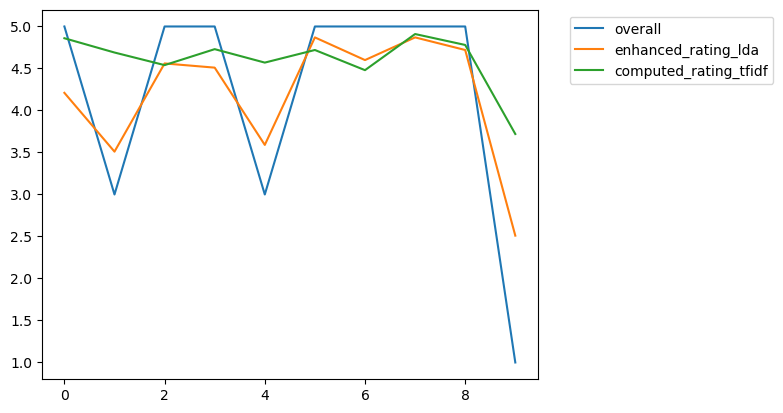

In [65]:
ax = comparison_df[:10].plot(kind='line')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

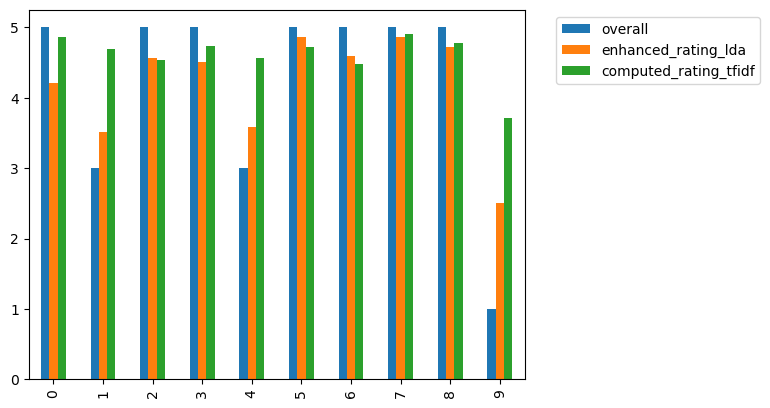

In [66]:
ax = comparison_df[:10].plot(kind='bar')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')